In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

Season 2008: Brier Score = 0.1617
Season 2009: Brier Score = 0.1892
Season 2010: Brier Score = 0.2034
Season 2011: Brier Score = 0.2319
Season 2012: Brier Score = 0.2120
Season 2013: Brier Score = 0.2226
Season 2014: Brier Score = 0.2029
Season 2015: Brier Score = 0.1785
Season 2016: Brier Score = 0.1997
Season 2017: Brier Score = 0.2042
Season 2018: Brier Score = 0.2195
Season 2019: Brier Score = 0.1864
Season 2021: Brier Score = 0.2342
Season 2022: Brier Score = 0.2563
Season 2023: Brier Score = 0.2228
Season 2024: Brier Score = 0.2103
Average Brier score: 0.20847487079113716


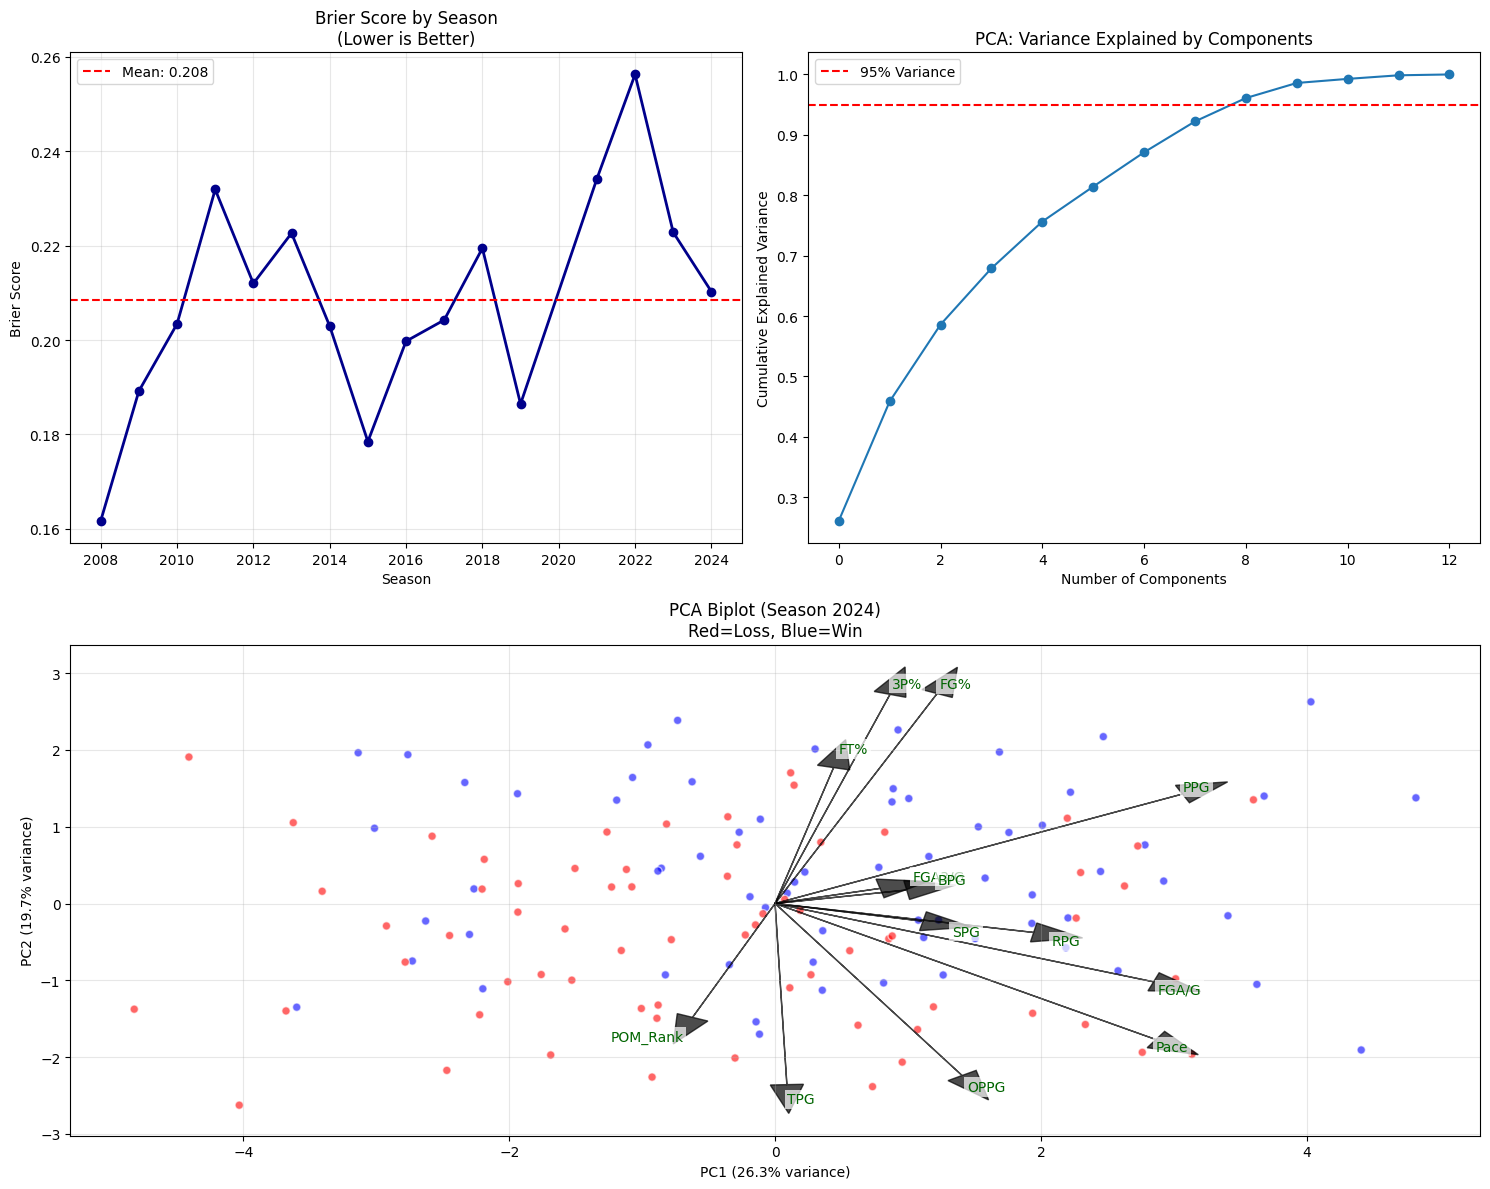


=== Brier Score Results ===
 Season  Brier Score
   2008     0.161655
   2009     0.189166
   2010     0.203401
   2011     0.231906
   2012     0.211985
   2013     0.222645
   2014     0.202946
   2015     0.178473
   2016     0.199744
   2017     0.204241
   2018     0.219456
   2019     0.186442
   2021     0.234171
   2022     0.256288
   2023     0.222820
   2024     0.210259
Best Season: 2008 (0.1617)
Worst Season: 2022 (0.2563)


In [ ]:
    import pandas as pd
    import numpy as np
    import xgboost as xgb
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import brier_score_loss
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    # Load the data
    game_df = pd.read_csv('class_data/reg_season_final.csv')
    tourney_df = pd.read_csv('class_data/tourney_final.csv')


    # Features to use
    features = ['diff_PPG', 'diff_OPPG', 'diff_FG%', 
                'diff_FGA/G', 'diff_3P%', 'diff_FGA3/G', 'diff_FT%', 
                'diff_RPG', 'diff_TPG', 'diff_SPG', 'diff_BPG', 'diff_Pace', 
                'diff_POM_Rank']

    # Missing Vals
    game_df = game_df.dropna(subset=features)
    tourney_df = tourney_df.dropna(subset=features)


    # Initialize storage
    brier_scores = []
    seasons = sorted([s for s in tourney_df['Season'].unique() if s >= 2008])
    pca_results = []

    #Standardize features
    scaler = StandardScaler()
    X_all = pd.concat([game_df[features], tourney_df[features]])  
    scaler.fit(X_all)

    for season in seasons:
        # Train/test split
        train_data = game_df[game_df['Season'] < season]
        test_data = tourney_df[tourney_df['Season'] == season]
        
        if len(train_data) < 100 or len(test_data) == 0:
            print(f"Skipping {season} - insufficient data")
            continue
        
        X_train = scaler.transform(train_data[features])
        y_train = train_data['target']
        X_test = scaler.transform(test_data[features])
        y_test = test_data['target']
        
        #Apply PCA
        pca = PCA(n_components=2)
        X_train_pca = pca.fit_transform(X_train)
        pca_results.append({
            'season': season,
            'pca': pca,
            'train_pca': X_train_pca,
            'test_pca': pca.transform(X_test),
            'y_test': y_test
        })
        
        # Train model
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            n_estimators=150,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42
        )
        model.fit(X_train, y_train)
        
        # Evaluate with Brier score
        y_proba = model.predict_proba(X_test)[:, 1]
        brier_score = brier_score_loss(y_test, y_proba)
        brier_scores.append(brier_score)
        
        print(f"Season {season}: Brier Score = {brier_score:.4f}")

    print(f"Average Brier score: {sum(brier_scores)/len(brier_scores)}")

    # ======================
    # Visualization Section
    # ======================

    plt.figure(figsize=(15, 12))

    # 1. Brier Score Trend Plot
    plt.subplot(2, 2, 1)
    plt.plot(seasons[-len(brier_scores):], brier_scores, 
            marker='o', color='darkblue', linewidth=2)
    plt.axhline(y=np.mean(brier_scores), color='red', linestyle='--',
                label=f'Mean: {np.mean(brier_scores):.3f}')
    plt.xlabel('Season')
    plt.ylabel('Brier Score')
    plt.title('Brier Score by Season\n(Lower is Better)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # 2. PCA Variance Explained
    plt.subplot(2, 2, 2)
    pca = PCA().fit(scaler.transform(game_df[features]))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA: Variance Explained by Components')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
    plt.legend()

    # 3. PCA Biplot (Latest Season)
    latest_pca = pca_results[-1]
    X_pca = latest_pca['test_pca']
    y_test = latest_pca['y_test']

    plt.subplot(2, 2, (3,4))
    cmap = ListedColormap(['red', 'blue'])
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, 
                        cmap=cmap, alpha=0.6, edgecolors='w')

    # Add principal component arrows with labels on heads
    for i, feature in enumerate(features):
        # Calculate arrow end points
        x_end = latest_pca['pca'].components_[0, i] * 7
        y_end = latest_pca['pca'].components_[1, i] * 7
        
        # Draw the arrow (slightly thicker)
        arrow = plt.arrow(0, 0, 
                        x_end, y_end,
                        color='black', alpha=0.7, 
                        head_width=0.25,  # Slightly larger head
                        length_includes_head=True)
        
        # Place text at the arrowhead with smart positioning
        text_x = x_end * 0.9  # 90% along the arrow shaft
        text_y = y_end * 0.9
        
        # Adjust text alignment based on direction
        ha = 'left' if x_end > 0 else 'right'
        va = 'bottom' if y_end > 0 else 'top'
        
        plt.text(text_x, text_y, feature.replace('diff_', ''), 
                color='darkgreen', fontsize=10,
                ha=ha, va=va,
                bbox=dict(facecolor='white', alpha=0.7, 
                        edgecolor='none', pad=2))
            

    plt.xlabel(f"PC1 ({latest_pca['pca'].explained_variance_ratio_[0]*100:.1f}% variance)")
    plt.ylabel(f"PC2 ({latest_pca['pca'].explained_variance_ratio_[1]*100:.1f}% variance)")
    plt.title(f"PCA Biplot (Season {latest_pca['season']})\nRed=Loss, Blue=Win")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



    # Results summary
    print("\n=== Brier Score Results ===")
    results_df = pd.DataFrame({
        'Season': seasons[-len(brier_scores):],
        'Brier Score': brier_scores
    })
    print(results_df.to_string(index=False))

    print(f"Best Season: {results_df.loc[np.argmin(brier_scores), 'Season']} ({np.min(brier_scores):.4f})")
    print(f"Worst Season: {results_df.loc[np.argmax(brier_scores), 'Season']} ({np.max(brier_scores):.4f})")